<a href="https://colab.research.google.com/github/Divyaanshvats/Diffusion-models-2dim/blob/main/AIRL_ASSIGNMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **So in this project how we are going to proceed in the following way:**
1. Display the Real Data pictorially using Matplotlib
2. Preparation of Data for Diffusion, that is Normalizing it
3. Defining the Forward Diffusion Process.
4. Training the Noise prediction model.
5. DDIM Reverse Diffusion Process.
6. Genearting 1000 samples and displaying it by overlaying it along with the original once.
7. Trying the same with other models

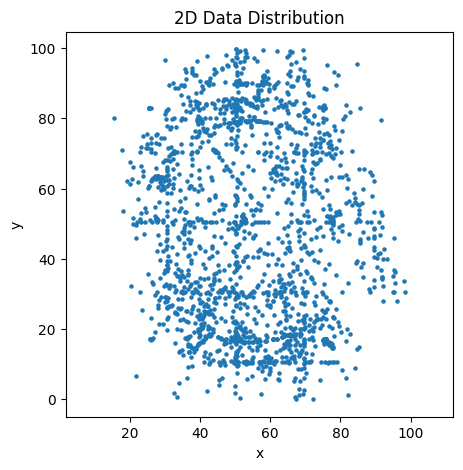

In [1]:
#Mapping of initial dataset
import pandas as pd
import matplotlib.pyplot as plt
data=pd.read_csv('/content/Datashape.tsv',sep="\t")
plt.figure(figsize=(5,5))
plt.scatter(data["x"],data['y'],s=5)
plt.title("2D Data Distribution")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.show()

# **Preparation of data for DIFFUSION training**

In [2]:
import torch
data_tensor=torch.tensor(data[["x","y"]].values,dtype=torch.float32)

In [3]:
#Here we normalize the data
data_mean=data_tensor.mean(dim=0)
data_std=data_tensor.std(dim=0)
data_tensor=(data_tensor-data_mean)/data_std

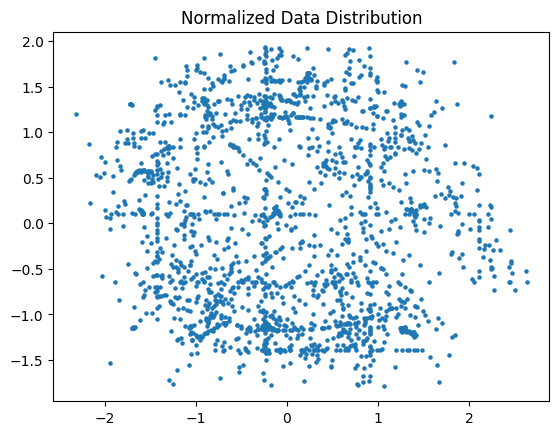

In [4]:
#Plotting again after Normalizing the data
plt.scatter(data_tensor[:,0],data_tensor[:,1],s=5)
plt.title("Normalized Data Distribution")
plt.axis("equal")
plt.show()

# **FORWARD DIFFUSION**

In [5]:
#DEFINING THE BASIC PARAMETERS
T=500# this is the total diffusion steps
beta=torch.linspace(1e-4,0.02,T)#this is the noise
alpha=1.0-beta
alpha_bar=torch.cumprod(alpha,dim=0)#this is the cumulative product

In [6]:
#Time embedding uses sine and cosine functions to represent each timestep in a smooth way.
#This helps the model understand how noisy the data is and how much noise to remove.
def time_embedding(t, dim=32):
    half=dim // 2
    freqs=torch.exp(
        -torch.arange(half, dtype=torch.float32) *
        torch.log(torch.tensor(10000.0))/(half - 1)
    )
    args = t[:, None].float() * freqs[None]
    return torch.cat([torch.sin(args), torch.cos(args)], dim=-1)

In [7]:
def forward_diffusion(x0,t,noise,alpha_bar):
  alpha_bar_t=alpha_bar[t]
  if alpha_bar_t.dim()==1:
    alpha_bar_t=alpha_bar_t.unsqueeze(1)
  else:
    alpha_bar_t=alpha_bar_t.unsqueeze(0)
  return torch.sqrt(alpha_bar_t)*x0+torch.sqrt(1-alpha_bar_t)*noise # This is the mathematical formula

In [8]:
#NEURAL NETWORK ARCHITECTURE
import torch.nn as nn
class DiffusionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.time_dim = 32 # Initialize time_dim
    self.net=nn.Sequential(
        nn.Linear(2 + self.time_dim, 128),
        nn.ReLU(),
        nn.Linear(128,256),
        nn.ReLU(),
        nn.Linear(256,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128,2)
    )
  def forward(self,x,t):
    t_emb=time_embedding(t,self.time_dim)
    x=torch.cat([x,t_emb],dim=1)
    return self.net(x)

In [9]:
#The training part
model=DiffusionModel()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
loss_fn=nn.MSELoss()
epochs=200
for epoch in range(epochs):
    t=torch.randint(0,T,(data_tensor.shape[0],))
    noise=torch.randn_like(data_tensor)
    x_t=forward_diffusion(data_tensor,t,noise,alpha_bar)
    noise_pred=model(x_t,t)

    loss=loss_fn(noise_pred,noise)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 1.0076
Epoch 10, Loss: 0.6465
Epoch 20, Loss: 0.4736
Epoch 30, Loss: 0.4107
Epoch 40, Loss: 0.3999
Epoch 50, Loss: 0.3686
Epoch 60, Loss: 0.3720
Epoch 70, Loss: 0.3824
Epoch 80, Loss: 0.3873
Epoch 90, Loss: 0.3954
Epoch 100, Loss: 0.3799
Epoch 110, Loss: 0.3721
Epoch 120, Loss: 0.3978
Epoch 130, Loss: 0.3749
Epoch 140, Loss: 0.3974
Epoch 150, Loss: 0.4060
Epoch 160, Loss: 0.3653
Epoch 170, Loss: 0.3726
Epoch 180, Loss: 0.3815
Epoch 190, Loss: 0.4006


# **REVERSE DIFFUSION**

In [10]:
model.eval()
#Sampling function below:
beta = 1 - alpha
@torch.no_grad()
def sample(model, n_sample,T,alpha,alpha_bar):
  x=torch.randn(n_sample,2)
  for t in reversed(range(T)):
    t_tensor=torch.full((n_sample,),t,dtype=torch.long)
    eps_pred=model(x,t_tensor)
    alpha_t=alpha[t]
    alpha_bar_t=alpha_bar[t]
    beta_t=beta[t]
    if t>0:
      noise=torch.randn_like(x)
    else:
      noise=torch.zeros_like(x)
    x=(1/torch.sqrt(alpha_t))*(x-(beta_t/torch.sqrt(1-alpha_bar_t))*eps_pred)+torch.sqrt(beta_t) * noise #Mathematical equation for reverse diffusion
  return x

In [11]:
generated=sample(model, 1000, T, alpha, alpha_bar)

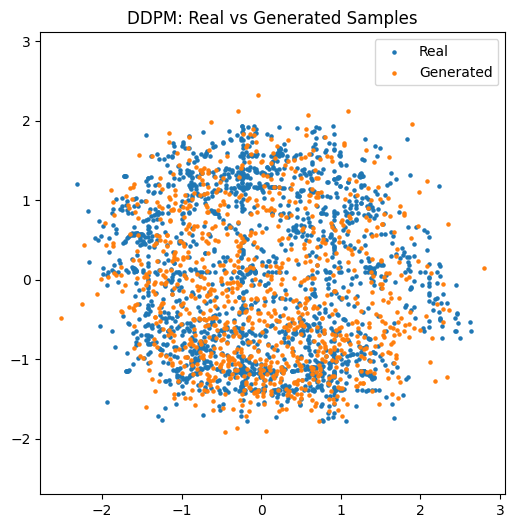

In [12]:
plt.figure(figsize=(6,6))
plt.scatter(data_tensor[:,0], data_tensor[:,1], s=5, label="Real")
plt.scatter(generated[:,0], generated[:,1], s=5, label="Generated")
plt.legend()
plt.axis("equal")
plt.title("DDPM: Real vs Generated Samples")
plt.show()

# **OTHER DIFFUSION MODELS:**

# **Score Based Diffusion**

In [13]:
class ScoreModel(nn.Module):
    """
    Wraps the DDPM noise predictor as a score-based model
    """
    def __init__(self, ddpm_model, alpha_bar):
        super().__init__()
        self.ddpm_model = ddpm_model
        self.alpha_bar = alpha_bar

    def forward(self, x, t):
        """
        Returns score: ∇_x log p(x_t)
        """
        eps_pred=self.ddpm_model(x, t)
        alpha_bar_t=self.alpha_bar[t]

        if alpha_bar_t.dim()==0:
            alpha_bar_t=alpha_bar_t.unsqueeze(0)
        else:
            alpha_bar_t=alpha_bar_t.unsqueeze(1)

        score=-eps_pred/torch.sqrt(1-alpha_bar_t)
        return score


In [14]:
@torch.no_grad()
def sample_score_based(score_model, n_samples, T, step_size=0.01):
    """
    Score-based sampling using Langevin dynamics
    """
    x = torch.randn(n_samples, 2)

    for t in reversed(range(T)):
        t_tensor = torch.full((n_samples,), t, dtype=torch.long)
        score = score_model(x, t_tensor)
        # Langevin update
        noise = torch.randn_like(x)
        x = x + step_size * score + torch.sqrt(torch.tensor(2 * step_size)) * noise

    return x


In [15]:
score_model = ScoreModel(model, alpha_bar)
generated_score = sample_score_based(
    score_model,
    n_samples=1000,
    T=T,
    step_size=0.01
)


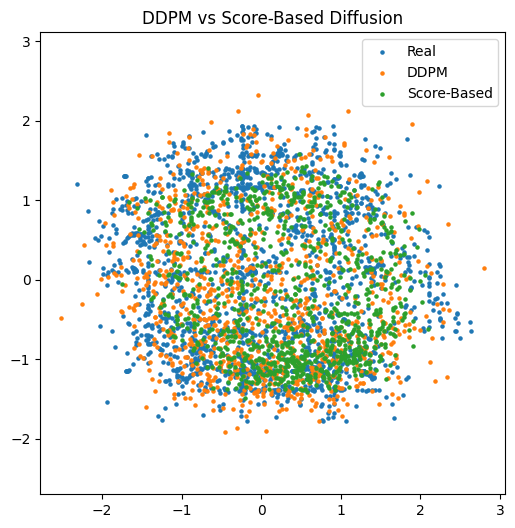

In [16]:
plt.figure(figsize=(6,6))
plt.scatter(data_tensor[:,0], data_tensor[:,1], s=5, label="Real")
plt.scatter(generated[:,0], generated[:,1], s=5, label="DDPM")
plt.scatter(generated_score[:,0], generated_score[:,1], s=5, label="Score-Based")
plt.legend()
plt.axis("equal")
plt.title("DDPM vs Score-Based Diffusion")
plt.show()

# **Variance Exploding (VE) Score Based Diffusion**

In [17]:
def ve_sigma(t, sigma_min=0.01, sigma_max=50.0, T=500):
    """
    Exponential noise schedule for VE diffusion
    """
    return sigma_min * (sigma_max / sigma_min) ** (t / T)

In [18]:
class VEScoreModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
    def forward(self, x, t):
        eps = self.base_model(x, t)
        sigma_t = ve_sigma(t.float())
        sigma_t = sigma_t.unsqueeze(1)
        return -eps / sigma_t

In [19]:
@torch.no_grad()
def sample_ve(score_model, n_samples, T, step_size=0.005):
    x=torch.randn(n_samples, 2) * ve_sigma(torch.tensor(T))

    for t in reversed(range(T)):
        t_tensor=torch.full((n_samples,), t, dtype=torch.long)
        score=score_model(x, t_tensor)

        noise=torch.randn_like(x)
        x=x + step_size * score + torch.sqrt(torch.tensor(2 * step_size)) * noise

    return x

In [20]:
ve_score_model=VEScoreModel(model)

generated_ve=sample_ve(
    ve_score_model,
    n_samples=1000,
    T=T
)

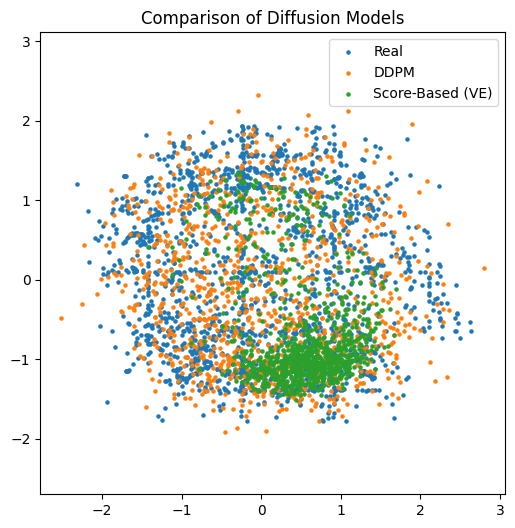

In [21]:
plt.figure(figsize=(6,6))
plt.scatter(data_tensor[:,0], data_tensor[:,1], s=5, label="Real")
plt.scatter(generated[:,0], generated[:,1], s=5, label="DDPM")
plt.scatter(generated_ve[:,0], generated_ve[:,1], s=5, label="Score-Based (VE)")
plt.legend()
plt.axis("equal")
plt.title("Comparison of Diffusion Models")
plt.show()
